In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path as op
import re
from datetime import datetime
import pickle
import joblib
from scipy import stats
from scipy.stats import linregress, chi2_contingency, ttest_ind, pearsonr
from scipy.linalg import lstsq
from tqdm.auto import tqdm
from collections import OrderedDict

from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.metrics import median_absolute_error, r2_score, explained_variance_score, mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import afqinsight
from afqinsight.match import mahalonobis_dist_match

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

import groupyr
from groupyr.transform import GroupExtractor
from groupyr.decomposition import GroupPCA

import arviz as az
import bambi as bmb
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

COLUMN_WIDTH = 246.0  # in points
FULL_TEXT_WIDTH = 510.0  # in points
FULL_TEXT_LENGTH = 660.0  # in points
RANDOM_SEED = 1729

# pd.set_option('display.max_rows', None)  # Show all rows

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_subset_indices(X_full, X_subset, method='hash'):
    """
    Find row indices in X_full that correspond to rows in X_subset.
    Supports 'hash' (fast) and 'precise' (element-wise) matching.
    """
    if X_full.shape[1] != X_subset.shape[1]:
        raise ValueError(f"Feature dimensions don't match: {X_full.shape[1]} vs {X_subset.shape[1]}")
    indices = []
    if method == 'precise':
        for i, subset_row in enumerate(X_subset):
            matches = [j for j, full_row in enumerate(X_full)
                       if np.array_equal(full_row, subset_row, equal_nan=True)]
            if not matches:
                raise ValueError(f"No matching row found for subset row {i}")
            indices.append(matches[0])
    elif method == 'hash':
        full_hashes = [hash(row.tobytes()) for row in X_full]
        for i, subset_row in enumerate(X_subset):
            subset_hash = hash(subset_row.tobytes())
            try:
                indices.append(full_hashes.index(subset_hash))
            except ValueError:
                raise ValueError(f"No matching row found for subset row {i}")
    else:
        raise ValueError(f"Unknown method '{method}'. Use 'hash' or 'precise'.")
    return np.array(indices)

class IdentityTransformer(BaseEstimator, TransformerMixin):
    """A transformer that returns the input unchanged."""
    def fit(self, X, y=None): return self
    def transform(self, X): return X

class CovariateRegressor(BaseEstimator, TransformerMixin):
    """
    Fits covariate(s) onto each feature in X and returns their residuals.
    """
    def __init__(self, covariate, X, pipeline=None, cross_validate=True, precise=False, unique_id_col_index=None, stack_intercept=True):
        """ Regresses out a variable (covariate) from each feature in X.

        Parameters
        ----------
        covariate : numpy array
            Array of length (n_samples, n_covariates) to regress out of each
            feature; May have multiple columns for multiple covariates.
        X : numpy array
            Array of length (n_samples, n_features), from which the covariate
            will be regressed. This is used to determine how the
            covariate-models should be cross-validated (which is necessary
            to use in in scikit-learn Pipelines).
        cross_validate : bool
            Whether to cross-validate the covariate-parameters (y~covariate)
            estimated from the train-set to the test set (cross_validate=True)
            or whether to fit the covariate regressor separately on the test-set
            (cross_validate=False). Setting this parameter to True is equivalent
            to "foldwise covariate regression" (FwCR) as described in our paper
            (https://www.biorxiv.org/content/early/2018/03/28/290684). Setting
            this parameter to False, however, is NOT equivalent to "whole
            dataset covariate regression" (WDCR) as it does not apply covariate
            regression to the *full* dataset, but simply refits the covariate
            model on the test-set. We recommend setting this parameter to True.
        precise: bool
            Transformer-objects in scikit-learn only allow to pass the data
            (X) and optionally the target (y) to the fit and transform methods.
            However, we need to index the covariate accordingly as well. To do so,
            we compare the X during initialization (self.X) with the X passed to
            fit/transform. As such, we can infer which samples are passed to the
            methods and index the covariate accordingly. When setting precise to
            True, the arrays are compared feature-wise, which is accurate, but
            relatively slow. When setting precise to False, it will infer the index
            by looking at the hash of all the features, which is much
            faster. Also, to aid the accuracy, we remove the features which are constant 
            (0) across samples.
        stack_intercept : bool
            Whether to stack an intercept to the covariate (default is True)

        Attributes
        ----------
        weights_ : numpy array
            Array with weights for the covariate(s).
        """
        self.covariate = covariate.astype(np.float64)
        self.cross_validate = cross_validate
        self.X = X
        self.precise = precise
        self.stack_intercept = stack_intercept
        self.weights_ = None
        self.pipeline = pipeline
        self.imputer = SimpleImputer(strategy="median")
        self.X_imputer = SimpleImputer(strategy="median")
        self.unique_id_col_index = unique_id_col_index
    
    def _prepare_covariate(self, covariate):
        """Prepare covariate matrix (adds intercept if needed)"""
        if self.stack_intercept:
            return np.c_[np.ones((covariate.shape[0], 1)), covariate]
        return covariate
    
    def fit(self, X, y=None):
        """ Fits the covariate-regressor to X.

        Parameters
        ----------
        X : numpy array
            An array of shape (n_samples, n_features), which should correspond
            to your train-set only!
        y : None
            Included for compatibility; does nothing.
        """
        
        # Prepare covariate matrix (adds intercept if needed)
        covariate = self._prepare_covariate(self.covariate)
        
        # Find indices of X subset in the original X
        method = 'precise' if self.precise else 'hash'
        fit_idx = find_subset_indices(self.X, X, method=method)
        
        # Remove unique ID column if specified
        if self.unique_id_col_index is not None:
            X = np.delete(X, self.unique_id_col_index, axis=1)
        
        # Extract covariate data for the fitting subset
        covariate_fit = covariate[fit_idx, :]
        
        # Conditional imputation for covariate data
        if np.isnan(covariate_fit).any():
            covariate_fit = self.imputer.fit_transform(covariate_fit)
        else:
            # Still fit the imputer for consistency in transform
            self.imputer.fit(covariate_fit)
        
        # Apply pipeline transformation if specified
        if self.pipeline is not None:
            X = self.pipeline.fit_transform(X)
        
        # Conditional imputation for X
        if np.isnan(X).any():
            X = self.X_imputer.fit_transform(X)
        else:
            # Still fit the imputer for consistency in transform
            self.X_imputer.fit(X)
        
        # Fit linear regression: X = covariate * weights + residuals
        # Using scipy's lstsq for numerical stability
        self.weights_ = lstsq(covariate_fit, X)[0]
        
        return self

    def transform(self, X):
        """ Regresses out covariate from X.

        Parameters
        ----------
        X : numpy array
            An array of shape (n_samples, n_features), which should correspond
            to your train-set only!

        Returns
        -------
        X_new : ndarray
            ndarray with covariate-regressed features
        """

        if not self.cross_validate:
            self.fit(X)

        # Prepare covariate matrix (adds intercept if needed)
        covariate = self._prepare_covariate(self.covariate)
        
        # Find indices of X subset in the original X
        method = 'precise' if self.precise else 'hash'  
        transform_idx = find_subset_indices(self.X, X, method=method)

        # Remove unique ID column if specified
        if self.unique_id_col_index is not None:    
            X = np.delete(X, self.unique_id_col_index, axis=1)
        
        # Extract covariate data for the transform subset
        covariate_transform = covariate[transform_idx]

        # Conditional imputation for covariate data (use fitted imputer)
        if np.isnan(covariate_transform).any():
            covariate_transform = self.imputer.transform(covariate_transform)
        
        # Apply pipeline transformation if specified
        if self.pipeline is not None:
            X = self.pipeline.transform(X)
        
        # Conditional imputation for X (use fitted imputer)
        if np.isnan(X).any():
            X = self.X_imputer.transform(X)
        
        # Compute residuals
        X_new = X - covariate_transform.dot(self.weights_)
        
        # Ensure no NaNs in output
        X_new = np.nan_to_num(X_new)
        
        return X_new

def get_cv_results(
    X_brain, X_covariates, y, groups=None,
    n_repeats=5, n_splits=10, n_estimators=10,
    feature_transformer=None, feature_transformer_kwargs={},
    target_transform_func=None, target_transform_inverse_func=None,
    ensembler=None, shuffle=False, regress_covariates=True,
):
    """
    Run cross-validation for brain features with/without covariate regression and covariates-only models.
    Returns a dictionary of results for each fold.
    """
    y_fit = np.random.default_rng().permutation(y) if shuffle else np.copy(y)
    X_brain_data = np.copy(X_brain)
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1729)
    cv_results = {}

    base_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_brain_data, y_fit)):
        start = datetime.now()
        X_train, X_test = X_brain_data[train_idx], X_brain_data[test_idx]
        X_train_covariates, X_test_covariates = X_covariates[train_idx], X_covariates[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]

        covariates_pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("estimator", LassoCV(verbose=False, n_jobs=1, fit_intercept=True))
        ])

        if regress_covariates:
            class BrainTransformerCovariatesRegressed(Pipeline, TransformerMixin):
                def __init__(self):
                    steps = [("covariate_regression", CovariateRegressor(X_covariates, X_brain_data, pipeline=base_pipeline))]
                    if feature_transformer is not None:
                        steps.append(("feature_transformer", feature_transformer(**feature_transformer_kwargs)))
                    else:
                        steps.append(("identity", IdentityTransformer()))
                    super().__init__(steps)
            brain_transformer_class = BrainTransformerCovariatesRegressed
        else:
            class BrainTransformerRaw(Pipeline, TransformerMixin):
                def __init__(self):
                    steps = [
                        ("imputer", SimpleImputer(strategy="median")),
                        ("scaler", StandardScaler())
                    ]
                    if feature_transformer is not None:
                        steps.append(("feature_transformer", feature_transformer(**feature_transformer_kwargs)))
                    else:
                        steps.append(("identity", IdentityTransformer()))
                    super().__init__(steps)
            brain_transformer_class = BrainTransformerRaw

        brain_pipe = afqinsight.pipeline.make_base_afq_pipeline(
            imputer=IdentityTransformer,
            feature_transformer=brain_transformer_class,
            feature_transformer_kwargs={},
            scaler=IdentityTransformer,
            estimator=LassoCV,
            estimator_kwargs={
                "verbose": False,
                "n_jobs": 1,
                "max_iter": 10000,
                "fit_intercept": True
            },
            ensemble_meta_estimator=ensembler,
            ensemble_meta_estimator_kwargs={
                "n_estimators": n_estimators,
                "n_jobs": 1,
                "oob_score": True,
                "random_state": 1729
            } if ensembler else None,
            target_transform_func=target_transform_func,
            target_transform_inverse_func=target_transform_inverse_func
        )

        covariates_pipe.fit(X_train_covariates, y_train)
        brain_pipe.fit(X_train, y_train)

        y_pred_brain_test = brain_pipe.predict(X_test)
        y_pred_covariates_test = covariates_pipe.predict(X_test_covariates)
        y_pred_brain_train = brain_pipe.predict(X_train)
        y_pred_covariates_train = covariates_pipe.predict(X_train_covariates)

        cv_results[cv_idx] = {
            "y_true": y_test,
            "y_pred_brain": y_pred_brain_test,
            "y_pred_covariates": y_pred_covariates_test,
            "brain_test_mae": median_absolute_error(y_test, y_pred_brain_test),
            "brain_test_r2": r2_score(y_test, y_pred_brain_test),
            "covariates_test_mae": median_absolute_error(y_test, y_pred_covariates_test),
            "covariates_test_r2": r2_score(y_test, y_pred_covariates_test),
            "brain_train_mae": median_absolute_error(y_train, y_pred_brain_train),
            "brain_train_r2": r2_score(y_train, y_pred_brain_train),
            "covariates_train_mae": median_absolute_error(y_train, y_pred_covariates_train),
            "covariates_train_r2": r2_score(y_train, y_pred_covariates_train),
            "covariates_coefs": covariates_pipe.named_steps["estimator"].coef_,
            "covariates_alpha": covariates_pipe.named_steps["estimator"].alpha_,
            "train_idx": train_idx,
            "test_idx": test_idx
        }
        print(f"CV fold {cv_idx:3d} completed in {datetime.now() - start}")
    return cv_results

def summarize_cv_results(all_results):
    print("=" * 50)
    print("MODEL PERFORMANCE METRICS")
    print("=" * 50)
    
    # Get covariates-only model results from any of the result sets (they're identical)
    first_results = next(iter(all_results.values()))
    covariates_test_r2 = [cv_res["covariates_test_r2"] for cv_res in first_results.values()]
    covariates_test_mae = [cv_res["covariates_test_mae"] for cv_res in first_results.values()]
    covariates_train_r2 = [cv_res["covariates_train_r2"] for cv_res in first_results.values()]
    covariates_train_mae = [cv_res["covariates_train_mae"] for cv_res in first_results.values()]
    
    def mean_sem(arr):
        arr = np.array(arr)
        return np.mean(arr), np.std(arr) / np.sqrt(len(arr))
    
    print("\nCovariates-Only Model:")
    print("-" * 30)
    print(f"  Train R2: {mean_sem(covariates_train_r2)[0]:.4f} ± {mean_sem(covariates_train_r2)[1]:.4f}")
    print(f"  Test R2:  {mean_sem(covariates_test_r2)[0]:.4f} ± {mean_sem(covariates_test_r2)[1]:.4f}")
    print(f"  Train MAE: {mean_sem(covariates_train_mae)[0]:.4f} ± {mean_sem(covariates_train_mae)[1]:.4f}")
    print(f"  Test MAE:  {mean_sem(covariates_test_mae)[0]:.4f} ± {mean_sem(covariates_test_mae)[1]:.4f}")
    
    # Rest of the function stays the same
    for model_name, res in all_results.items():
        brain_test_r2 = [cv_res["brain_test_r2"] for cv_res in res.values()]
        brain_test_mae = [cv_res["brain_test_mae"] for cv_res in res.values()]
        brain_train_r2 = [cv_res["brain_train_r2"] for cv_res in res.values()]
        brain_train_mae = [cv_res["brain_train_mae"] for cv_res in res.values()]
        
        print(f"\nBrain Model - {model_name}:")
        print("-" * 30)
        print(f"  Train R2: {mean_sem(brain_train_r2)[0]:.4f} ± {mean_sem(brain_train_r2)[1]:.4f}")
        print(f"  Test R2:  {mean_sem(brain_test_r2)[0]:.4f} ± {mean_sem(brain_test_r2)[1]:.4f}")
        print(f"  Train MAE: {mean_sem(brain_train_mae)[0]:.4f} ± {mean_sem(brain_train_mae)[1]:.4f}")
        print(f"  Test MAE:  {mean_sem(brain_test_mae)[0]:.4f} ± {mean_sem(brain_test_mae)[1]:.4f}")

def plot_single_pyramid(ax, dbp_ages, dhcp_full_ages, dhcp_matched_ages, ylabel, panel_label, bins=20):
    """
    Create a single population pyramid subplot
    """
    # Create common bins for all datasets
    min_age = min(dbp_ages.min(), dhcp_full_ages.min(), dhcp_matched_ages.min())
    max_age = max(dbp_ages.max(), dhcp_full_ages.max(), dhcp_matched_ages.max())
    bin_edges = np.linspace(min_age, max_age, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Count frequencies for each dataset
    hist_dbp, _ = np.histogram(dbp_ages, bins=bin_edges)
    hist_dhcp_full, _ = np.histogram(dhcp_full_ages, bins=bin_edges)
    hist_dhcp_matched, _ = np.histogram(dhcp_matched_ages, bins=bin_edges)
    
    # Plot DBP on the left (negative values)
    ax.barh(bin_centers, -hist_dbp, height=np.diff(bin_edges), 
            color='seagreen', alpha=0.8, label='LPCH')
    
    # Plot dHCP full on the right (positive values, darker)
    ax.barh(bin_centers, hist_dhcp_full, height=np.diff(bin_edges), 
            color='coral', alpha=0.5, label='dHCP (full)')
    
    # Plot dHCP matched on the right (positive values, lighter, overlaid)
    ax.barh(bin_centers, hist_dhcp_matched, height=np.diff(bin_edges), 
            color='lightblue', alpha=1, label='dHCP (GA<=224)')
    
    # Formatting
    ax.set_xlabel('Count of subjects')
    ax.set_ylabel(ylabel, rotation=0, labelpad=40)  # Custom ylabel with more padding
    ax.grid(True, alpha=0.3)
    ax.axvline(0, color='black', linewidth=0.8)
    
    # Change x-axis to show absolute values
    ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])
    
    # Add month guidelines (dotted lines) - assuming age is in days
    month_days = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]  # 1-12 months
    month_labels = ['1mo', '2mo', '3mo', '4mo', '5mo', '6mo', '7mo', '8mo', '9mo', '10mo', '11mo', '12mo']
    
    # Only show month lines that fall within our data range
    for days, label in zip(month_days, month_labels):
        if min_age <= days <= max_age:
            ax.axhline(y=days, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
            # Add month label on the right side
            ax.text(ax.get_xlim()[1] * 0.95, days, label, 
                   verticalalignment='center', horizontalalignment='right',
                   fontsize=8, alpha=0.7)
    
    # Add panel label (A, B, C)
    ax.text(0.02, 0.98, panel_label, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='left',
            fontsize=14, fontweight='bold')
    
    # Sample sizes will be included in figure caption instead of on plot
    
    return ax

def plot_three_dataset_facets(df_dbp_matched, df_dhcp_ages, df_dhcp_matched, feature_cols):
    """
    Create side-by-side population pyramid plots for all three age variables
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Define custom labels and panel labels
    ylabels = {
        'mri_pma': 'Post-menstrual\nAge at Scan',
        'gestational_age': 'Gestational\nAge', 
        'chronological_age': 'Chronological\nAge'
    }
    panel_labels = ['A', 'B', 'C']
    
    for i, col in enumerate(feature_cols):
        plot_single_pyramid(
            axes[i],
            df_dbp_matched[col], 
            df_dhcp_ages[col], 
            df_dhcp_matched[col],
            ylabels[col],
            panel_labels[i]
        )
        
        # Add legend only to the rightmost subplot
        if i == 2:
            axes[i].legend(loc='upper right')
    
    plt.tight_layout()
    return fig, axes

def average_cv_predictions(cv_results):
    """Average predictions across CV folds for each sample"""
    cumulative_sums = {}
    counts = {}
    y_true_dict = {}  # Also collect y_true values
    
    for cv_idx in cv_results:
        test_idx = cv_results[cv_idx]["test_idx"]
        y_pred_brain = cv_results[cv_idx]["y_pred_brain"]
        y_true_fold = cv_results[cv_idx]["y_true"]
        
        for idx, pred, true_val in zip(test_idx, y_pred_brain, y_true_fold):
            cumulative_sums[idx] = cumulative_sums.get(idx, 0) + pred
            counts[idx] = counts.get(idx, 0) + 1
            y_true_dict[idx] = true_val  # Store y_true (same across folds for same idx)
    
    # Calculate averages and return as sorted DataFrame
    averaged_preds = {idx: cumulative_sums[idx] / counts[idx] for idx in cumulative_sums}
    df = pd.DataFrame({
        'idx': list(averaged_preds.keys()),
        'y_pred': list(averaged_preds.values()),
        'y_true': [y_true_dict[idx] for idx in averaged_preds.keys()]
    })
    return df.sort_values('idx').reset_index(drop=True)

In [3]:
"""
Download all csv files used in this notebook from https://doi.org/10.6084/m9.figshare.c.7847159
Place them in the same directory as this notebook
"""

'\nDownload all csv files used in this notebook from https://doi.org/10.6084/m9.figshare.c.7847159\nPlace them in the same directory as this notebook\n'

In [4]:
df_dbp = pd.read_csv('dbp_caredata_w_mri_apr2025.csv')
df_dbp['sex'] = df_dbp['gender']
df_dhcp_dedup = pd.read_csv('dhcp_targets_1scan_grotheerQC.csv') 
df_dhcp_ga224 = pd.read_csv('dhcp_targets_matched_gaceiling_grotheerQC.csv') 

/tmp/ipykernel_22907/2672017841.py:379: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])
/tmp/ipykernel_22907/2672017841.py:379: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])
/tmp/ipykernel_22907/2672017841.py:379: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])


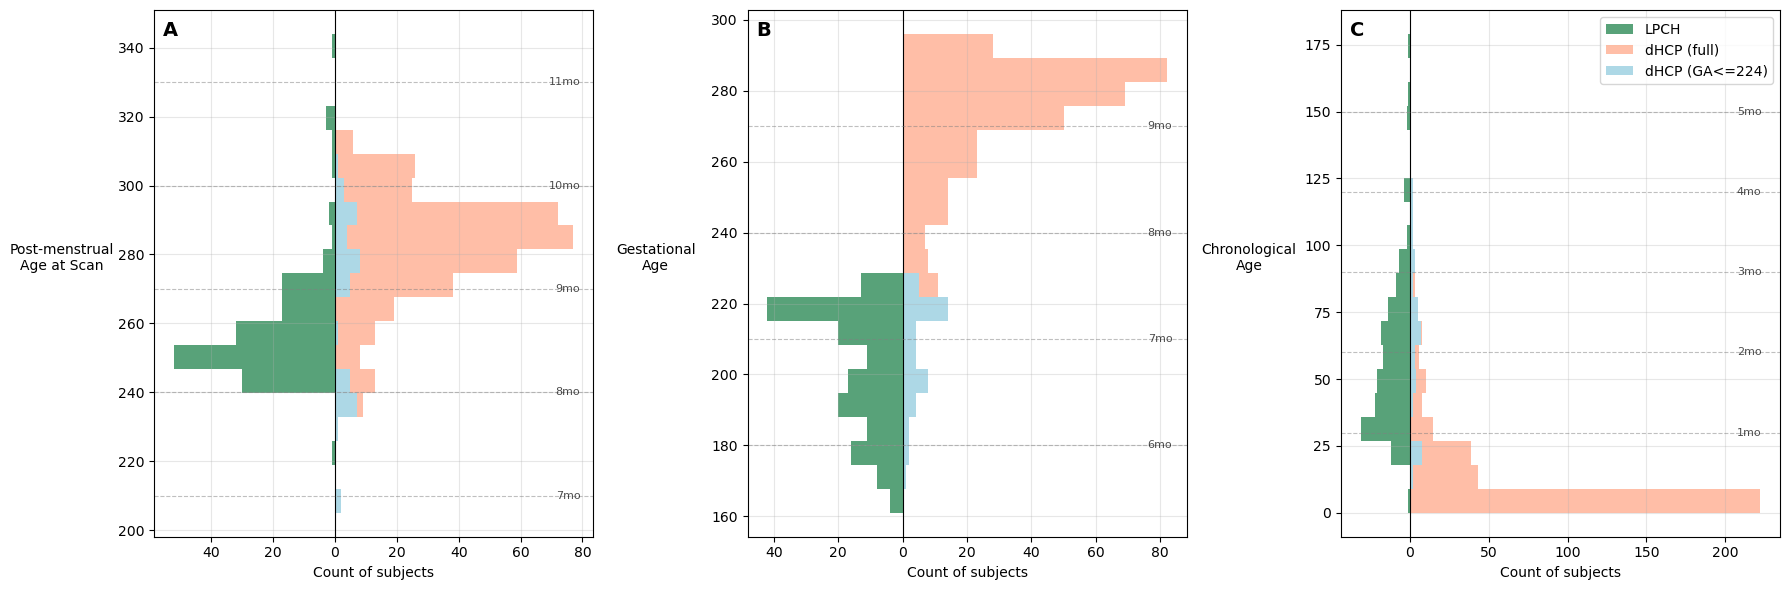

In [5]:
"""
Figure 2. Age distribution comparison across both dHCP and LPCH datasets. 
"""

feature_cols = ['mri_pma', 'gestational_age', 'chronological_age']

pd.set_option('display.max_rows', None)  # Show all rows

# Create side-by-side faceted plots
fig, axes = plot_three_dataset_facets(df_dbp, df_dhcp_dedup, df_dhcp_ga224, feature_cols)

plt.show()

In [6]:
"""
Table 1. Demographic characteristics of study participants from dHCP and LPCH cohorts.
"""

# Get sample sizes
dhcp_total = len(df_dhcp_dedup)
lpch_total = len(df_dbp)

# Summary table
print("="*80)
print("SUMMARY TABLE")
print("="*80)

print(f"{'Variable':<35} {f'dHCP (n = {dhcp_total})':<20} {f'LPCH (n = {lpch_total})':<20} {'Statistical Test':<20}")
print("-" * 95)

# 1. Sex distribution and chi-square test
dhcp_males = (df_dhcp_dedup['sex'].str.lower() == 'male').sum()
dhcp_females = (df_dhcp_dedup['sex'].str.lower() == 'female').sum()
lpch_males = (df_dbp['sex'].str.lower() == 'male').sum()
lpch_females = (df_dbp['sex'].str.lower() == 'female').sum()

dhcp_male_pct = dhcp_males/dhcp_total*100
lpch_male_pct = lpch_males/lpch_total*100

# Chi-square test
contingency_table = np.array([[dhcp_males, dhcp_females], 
                             [lpch_males, lpch_females]])
chi2_sex, p_sex, dof_sex, _ = chi2_contingency(contingency_table)

if p_sex < 0.001:
    p_sex_str = "p < .001"
elif p_sex < 0.05:
    p_sex_str = f"p = {p_sex:.3f}"
else:
    p_sex_str = f"p = {p_sex:.2f}"

print(f"{'Number of males (%)':<35} {f'{dhcp_males} ({dhcp_male_pct:.1f}%)':<20} {f'{lpch_males} ({lpch_male_pct:.1f}%)':<20} χ²({dof_sex}) = {chi2_sex:.3f}, {p_sex_str}")

# 2. Continuous variables and t-tests
continuous_vars = ['gestational_age', 'chronological_age', 'mri_pma']
var_names = ['Gestational age at birth (days)', 
             'Chronological age at scan (days)', 
             'Post-menstrual age at scan (days)']

for var, name in zip(continuous_vars, var_names):
    # Get data for both groups
    dhcp_data = df_dhcp_dedup[var].dropna()
    lpch_data = df_dbp[var].dropna()
    
    # Calculate descriptive statistics
    dhcp_mean = dhcp_data.mean()
    dhcp_std = dhcp_data.std()
    lpch_mean = lpch_data.mean()
    lpch_std = lpch_data.std()
    
    # Perform t-test
    t_stat, p_value = ttest_ind(dhcp_data, lpch_data)
    df_total = len(dhcp_data) + len(lpch_data) - 2
    
    # Format strings
    dhcp_str = f"{dhcp_mean:.2f} ({dhcp_std:.2f})"
    lpch_str = f"{lpch_mean:.2f} ({lpch_std:.2f})"
    
    if p_value < 0.001:
        p_str = "p < .001"
    elif p_value < 0.05:
        p_str = f"p = {p_value:.3f}"
    else:
        p_str = f"p = {p_value:.2f}"
    
    test_str = f"t({df_total}) = {t_stat:.2f}, {p_str}"
    
    print(f"{name:<35} {dhcp_str:<20} {lpch_str:<20} {test_str}")

print("="*80)

SUMMARY TABLE
Variable                            dHCP (n = 368)       LPCH (n = 162)       Statistical Test    
-----------------------------------------------------------------------------------------------
Number of males (%)                 205 (55.7%)          87 (53.7%)           χ²(1) = 0.110, p = 0.74
Gestational age at birth (days)     265.13 (26.86)       201.60 (17.03)       t(528) = 27.74, p < .001
Chronological age at scan (days)    15.46 (23.09)        56.33 (28.25)        t(528) = -17.49, p < .001
Post-menstrual age at scan (days)   280.59 (17.71)       257.93 (16.20)       t(528) = 13.92, p < .001


In [7]:
"""
Table 2. Model performance for predicting postmenstrual age at scan using white matter features in the dHCP cohort.
"""

afqdata = afqinsight.AFQDataset.from_files(
    fn_nodes="dhcp_features_1scan_grotheerQC.csv", 
    fn_subjects="dhcp_targets_1scan_grotheerQC.csv",
    dwi_metrics=["dti_md", "dti_fa"],
    target_cols=["mri_pma","chronological_age","gestational_age","sex","birthweight"],
    index_col="subjectID",
    label_encode_cols = ['sex']
)

X_md_fa = afqdata.X
X_covariates = afqdata.y[:, 3:]  # ["sex","birth_weight"]
y = afqdata.y[:,0]  # ["mri_pma"]
groups_md_fa = afqdata.groups
feature_names = afqdata.feature_names
group_names = afqdata.group_names
subjects = afqdata.subjects

results_covariates_regressed = get_cv_results(
    X_brain=X_md_fa, 
    X_covariates=X_covariates, 
    y=y,
    n_splits=5,
    n_repeats=40,
    feature_transformer=PCA,
    regress_covariates=True
)

results_covariates_raw = get_cv_results(
    X_brain=X_md_fa, 
    X_covariates=X_covariates, 
    y=y,
    n_splits=5,
    n_repeats=40,
    feature_transformer=PCA,
    regress_covariates=False
)

all_results = {
    'Covariates Regressed Out': results_covariates_regressed,
    'Covariates Not Regressed': results_covariates_raw
}

summarize_cv_results(all_results)

with open("dhcp_dedup_100_famd_n1_pma.pkl", "wb") as fp:
    pickle.dump(all_results, fp)

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


CV fold   0 completed in 0:00:00.412737
CV fold   1 completed in 0:00:00.398344
CV fold   2 completed in 0:00:00.411600
CV fold   3 completed in 0:00:00.403450
CV fold   4 completed in 0:00:00.402508
CV fold   5 completed in 0:00:00.405359
CV fold   6 completed in 0:00:00.403199
CV fold   7 completed in 0:00:00.413967
CV fold   8 completed in 0:00:00.407072
CV fold   9 completed in 0:00:00.419767
CV fold  10 completed in 0:00:00.396418
CV fold  11 completed in 0:00:00.398025
CV fold  12 completed in 0:00:00.391383
CV fold  13 completed in 0:00:00.394848
CV fold  14 completed in 0:00:00.393516
CV fold  15 completed in 0:00:00.402679
CV fold  16 completed in 0:00:00.400871
CV fold  17 completed in 0:00:00.398528
CV fold  18 completed in 0:00:00.398022
CV fold  19 completed in 0:00:00.404051
CV fold  20 completed in 0:00:00.392299
CV fold  21 completed in 0:00:00.399081
CV fold  22 completed in 0:00:00.400133
CV fold  23 completed in 0:00:00.399794
CV fold  24 completed in 0:00:00.397822


In [8]:
"""
Table 3. Model performance for predicting postmenstrual age at scan using white matter features in very preterm infants from the dHCP cohort.
"""

afqdata = afqinsight.AFQDataset.from_files(
    fn_nodes="dhcp_features_matched_gaceiling_grotheerQC.csv",
    fn_subjects="dhcp_targets_matched_gaceiling_grotheerQC.csv",
    dwi_metrics=["dti_md", "dti_fa"],
    target_cols=["mri_pma","gestational_age","chronological_age","sex","birthweight"],
    index_col="subjectID",
    label_encode_cols = ['sex']
)

X_md_fa = afqdata.X
X_covariates = afqdata.y[:, 3:]  # ["sex", "birth_weight"]
y = afqdata.y[:,0]  # ["mri_pma"]
groups_md_fa = afqdata.groups
feature_names = afqdata.feature_names
group_names = afqdata.group_names
subjects = afqdata.subjects
results_covariates_regressed = get_cv_results(
    X_brain=X_md_fa, 
    X_covariates=X_covariates, 
    y=y,
    n_splits=5,
    n_repeats=40,
    feature_transformer=PCA,
    regress_covariates=True
)

results_covariates_raw = get_cv_results(
    X_brain=X_md_fa, 
    X_covariates=X_covariates, 
    y=y,
    n_splits=5,
    n_repeats=40,
    feature_transformer=PCA,
    regress_covariates=False
)

all_results = {
    'Covariates Regressed Out': results_covariates_regressed,
    'Covariates Not Regressed': results_covariates_raw
}

summarize_cv_results(all_results)

with open("dhcp_ga224_100_famd_n1_pma.pkl", "wb") as fp:
   pickle.dump(all_results, fp)

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


CV fold   0 completed in 0:00:00.080780
CV fold   1 completed in 0:00:00.079663
CV fold   2 completed in 0:00:00.080859
CV fold   3 completed in 0:00:00.080788
CV fold   4 completed in 0:00:00.080996
CV fold   5 completed in 0:00:00.079266
CV fold   6 completed in 0:00:00.085263
CV fold   7 completed in 0:00:00.082443
CV fold   8 completed in 0:00:00.081942
CV fold   9 completed in 0:00:00.081558
CV fold  10 completed in 0:00:00.080397
CV fold  11 completed in 0:00:00.081500
CV fold  12 completed in 0:00:00.081273
CV fold  13 completed in 0:00:00.083304
CV fold  14 completed in 0:00:00.080453
CV fold  15 completed in 0:00:00.080612
CV fold  16 completed in 0:00:00.080841
CV fold  17 completed in 0:00:00.079536
CV fold  18 completed in 0:00:00.079135
CV fold  19 completed in 0:00:00.083536
CV fold  20 completed in 0:00:00.081208
CV fold  21 completed in 0:00:00.082022
CV fold  22 completed in 0:00:00.081609
CV fold  23 completed in 0:00:00.079494
CV fold  24 completed in 0:00:00.081206


In [9]:
"""
Table 4. Model performance for predicting postmenstrual age at scan using white matter features in the LPCH cohort.
"""

afqdata = afqinsight.AFQDataset.from_files(
    fn_nodes = 'dbp_neuro_preproc_postqc_apr2025.csv', 
    fn_subjects = "dbp_caredata_w_mri_apr2025.csv", 
    target_cols = ['mri_pma','health_acuity_sum','chronological_age','gestational_age', 'Public_insurance', 'birthweight', 'gender'],
    index_col="subjectID",
    label_encode_cols = ['gender']
)

X_md_fa = afqdata.X
X_covariates = afqdata.y[:, 5:]  # ['birthweight', 'gender']
y = afqdata.y[:,0]  # ["mri_pma"]
groups_md_fa = afqdata.groups
feature_names = afqdata.feature_names
group_names = afqdata.group_names
subjects = afqdata.subjects

results_covariates_regressed = get_cv_results(
    X_brain=X_md_fa, 
    X_covariates=X_covariates, 
    y=y,
    n_splits=5,
    n_repeats=40,
    feature_transformer=PCA,
    regress_covariates=True
)

results_covariates_raw = get_cv_results(
    X_brain=X_md_fa, 
    X_covariates=X_covariates, 
    y=y,
    n_splits=5,
    n_repeats=40,
    feature_transformer=PCA,
    regress_covariates=False
)

all_results = {
    'Covariates Regressed Out': results_covariates_regressed,
    'Covariates Not Regressed': results_covariates_raw
}

summarize_cv_results(all_results)

with open("lpch_100_famd_n1_pma.pkl", "wb") as fp:
    pickle.dump(all_results, fp)

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


CV fold   0 completed in 0:00:00.289775
CV fold   1 completed in 0:00:00.323294
CV fold   2 completed in 0:00:00.368741
CV fold   3 completed in 0:00:00.307837
CV fold   4 completed in 0:00:00.346079
CV fold   5 completed in 0:00:00.341734
CV fold   6 completed in 0:00:00.322220
CV fold   7 completed in 0:00:00.329609
CV fold   8 completed in 0:00:00.358066
CV fold   9 completed in 0:00:00.304525
CV fold  10 completed in 0:00:00.286027
CV fold  11 completed in 0:00:00.284856
CV fold  12 completed in 0:00:00.297056
CV fold  13 completed in 0:00:00.381762
CV fold  14 completed in 0:00:00.325986
CV fold  15 completed in 0:00:00.317789
CV fold  16 completed in 0:00:00.307054
CV fold  17 completed in 0:00:00.291333
CV fold  18 completed in 0:00:00.300339
CV fold  19 completed in 0:00:00.336352
CV fold  20 completed in 0:00:00.311967
CV fold  21 completed in 0:00:00.309799
CV fold  22 completed in 0:00:00.292013
CV fold  23 completed in 0:00:00.343000
CV fold  24 completed in 0:00:00.310983


In [10]:
"""
You can run the section below directly right after imports. PMA models for the three cohorts have been pickled.
"""

'\nYou can run the section below directly right after imports. PMA models for the three cohorts have been pickled.\n'

In [11]:
"""
Linear models
"""

MODEL_INFO_PATH = 'lpch_models_wide.csv'

df_modeldata = pd.read_csv(MODEL_INFO_PATH, low_memory=False)

# Load results
with open("lpch_100_famd_n1_pma.pkl", "rb") as fp:
    all_results = pickle.load(fp)

# Process both conditions
raw_results = average_cv_predictions(all_results['Covariates Not Regressed'])
clean_results = average_cv_predictions(all_results['Covariates Regressed Out'])

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'y_true': raw_results['y_true'],  # Now extracted from CV results
    'y_pred_raw': raw_results['y_pred'],
    'y_pred_clean': clean_results['y_pred']
})

# Calculate prediction gaps
# comparison_df['pma_gap_raw'] = comparison_df['y_pred_raw'] - comparison_df['y_true']
# comparison_df['pma_gap_clean'] = comparison_df['y_pred_clean'] - comparison_df['y_true']

# Merge based on index, assuming the order is the same in both dataframes
df_modeldata = pd.merge(df_modeldata, 
                        comparison_df[['y_pred_clean']], 
                        left_index=True, 
                        right_index=True, 
                        how='left')

df_modeldata = df_modeldata.merge(
    df_dbp[['gravidity', 'parity', 'subjectID']], 
    on='subjectID', 
    how='left'  
)

# Compute orthogonalized predicted age (de Lange and Cole method)
# Fit linear model Predicted_pma ~ PMA to get the slope and intercept
X_pma = sm.add_constant(df_modeldata["mri_pma"])
fit = sm.OLS(df_modeldata["y_pred_clean"], X_pma).fit()
intercept, slope = fit.params

# Rescale the predicted age
df_modeldata["mri_pma_orthogonal"] = (df_modeldata["y_pred_clean"] - intercept) / slope

# Define the RBAG
df_modeldata["rbag"] = df_modeldata["mri_pma_orthogonal"] - df_modeldata["mri_pma"]

# Encode `gender` variable as binary `male_sex`
le = LabelEncoder()
df_modeldata['male_sex'] = le.fit_transform(df_modeldata['sex'])  # males coded 1 (alphabetic)

# Standard scale the continuous predictors
for col in ["birthweight", "rbag", "mri_pma", "chronological_age", "gestational_age", "mother_age", "gravidity", "parity"]:
    df_modeldata[col] = (df_modeldata[col] - df_modeldata[col].mean()) / df_modeldata[col].std()

df_modeldata["health_acuity_sum"] = pd.Categorical(df_modeldata["health_acuity_sum"], ordered=True)

In [12]:
def create_violin_axes(nrows, ncols, figsize=(12,3)):
    fig, axes = plt.subplots(nrows, ncols, 
                       sharey = True,
                             figsize = figsize)
    
    fig.subplots_adjust(wspace = 0)

    def set_row_spines(ax_row):
        for idx, ax in enumerate(ax_row):
            ax.set_xticks([])
            
            if idx > 0:
                ax.spines['left'].set_visible(False)
                ax.tick_params(left = False)
        
            if idx < (ncols-1):
                ax.spines['right'].set_visible(False)

    if (len(axes.shape) == 1):
        set_row_spines(axes)
    else:
        for ax_row in axes:
            set_row_spines(ax_row)
            
    return fig, axes

def set_hlines(axes):
    for ax in np.array(axes).flatten():
        xmin, xmax = ax.get_xlim()
        ax.hlines(y = 0,
                  xmin = xmin,
                  xmax = xmax,
                  linestyle = ':',
                  color = 'black',
                  alpha = 0.5)

In [13]:
"""
Table S1. Bayesian Regression Model Predicting Health Acuity Sum Using Covariates Only in LPCH Cohort. 
"""

model_covars = bmb.Model("health_acuity_sum ~ birthweight + male_sex + Public_insurance",
                            family="cumulative",
                           data = df_modeldata,
                           dropna = True)

results_covars = model_covars.fit(idata_kwargs={"log_likelihood": True})
az.summary(results_covars)

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
Automatically removing 1/162 rows from the dataset.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [threshold, birthweight, male_sex, Public_insurance]
/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
threshold[0],-0.122,0.257,-0.616,0.351,0.004,0.004,3579.0,3162.0,1.0
threshold[1],1.581,0.301,1.001,2.134,0.005,0.005,4081.0,3192.0,1.0
threshold[2],3.100,0.486,2.161,3.972,0.007,0.007,4979.0,2894.0,1.0
birthweight,0.086,0.161,-0.232,0.369,0.002,0.003,5041.0,2801.0,1.0
male_sex,-0.414,0.320,-1.049,0.149,0.005,0.005,4251.0,3115.0,1.0
Public_insurance,-1.093,0.333,-1.680,-0.439,0.005,0.005,4483.0,3159.0,1.0


In [14]:
"""
Table S2. Bayesian Regression Model Predicting Health Acuity Sum Including Postmenstrual Age at Scan in LPCH Cohort.
"""

model_pma = bmb.Model("health_acuity_sum ~ mri_pma + birthweight + male_sex + Public_insurance",
                      family = "cumulative",
                           data = df_modeldata,
                           dropna = True)

results_pma = model_pma.fit(idata_kwargs={"log_likelihood": True})
az.summary(results_pma)

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
Automatically removing 1/162 rows from the dataset.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [threshold, mri_pma, birthweight, male_sex, Public_insurance]


/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
threshold[0],-0.113,0.274,-0.638,0.388,0.004,0.004,4239.0,3173.0,1.0
threshold[1],1.853,0.323,1.265,2.462,0.004,0.005,5210.0,3414.0,1.0
threshold[2],3.530,0.491,2.626,4.465,0.006,0.007,5894.0,3470.0,1.0
mri_pma,0.884,0.184,0.530,1.215,0.002,0.003,5684.0,3038.0,1.0
birthweight,0.108,0.172,-0.233,0.424,0.002,0.003,5610.0,2964.0,1.0
male_sex,-0.474,0.336,-1.103,0.153,0.005,0.005,4675.0,2815.0,1.0
Public_insurance,-1.035,0.364,-1.727,-0.343,0.005,0.006,4938.0,2945.0,1.0


In [15]:
"""
Table S3. Bayesian Regression Model Predicting Health Acuity Sum Including Postmenstrual Age at Scan in LPCH Cohort.
"""

model_caga = bmb.Model("health_acuity_sum ~ chronological_age + gestational_age + birthweight + male_sex + Public_insurance",
                      family = "cumulative",
                           data = df_modeldata,
                           dropna = True)

results_caga = model_caga.fit(idata_kwargs={"log_likelihood": True})
az.summary(results_caga)

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
Automatically removing 1/162 rows from the dataset.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [threshold, chronological_age, gestational_age, birthweight, male_sex, Public_insurance]


/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
threshold[0],-0.086,0.288,-0.641,0.431,0.006,0.004,2632.0,2524.0,1.0
threshold[1],2.125,0.332,1.484,2.741,0.005,0.005,4890.0,3306.0,1.0
threshold[2],3.859,0.497,2.891,4.792,0.007,0.008,5564.0,2947.0,1.0
chronological_age,0.904,0.330,0.326,1.553,0.006,0.005,2928.0,2727.0,1.0
gestational_age,-0.470,0.329,-1.078,0.162,0.006,0.005,3073.0,2775.0,1.0
birthweight,0.063,0.178,-0.265,0.399,0.002,0.003,5622.0,3180.0,1.0
male_sex,-0.527,0.358,-1.192,0.147,0.006,0.005,3569.0,2477.0,1.0
Public_insurance,-1.134,0.374,-1.867,-0.474,0.006,0.006,3910.0,2910.0,1.0


In [16]:
"""
Table S4. Bayesian Regression Model Predicting Health Acuity Sum Including Brain-Age Gap 
Derived From Raw White Matter Features in LPCH Cohort. 
"""

model_rbag = bmb.Model("health_acuity_sum ~ rbag + chronological_age + gestational_age + birthweight + male_sex + Public_insurance", 
                           family = "cumulative",
                             data = df_modeldata,
                           dropna = True)

results_rbag = model_rbag.fit(idata_kwargs={"log_likelihood": True})
az.summary(results_rbag)

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
Automatically removing 1/162 rows from the dataset.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [threshold, rbag, chronological_age, gestational_age, birthweight, male_sex, Public_insurance]


/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
threshold[0],-0.070,0.294,-0.651,0.457,0.006,0.004,2598.0,2558.0,1.0
threshold[1],2.152,0.335,1.545,2.790,0.005,0.005,4688.0,3280.0,1.0
threshold[2],3.878,0.497,3.004,4.857,0.007,0.008,5733.0,3085.0,1.0
rbag,-0.211,0.199,-0.595,0.138,0.003,0.003,3856.0,2668.0,1.0
chronological_age,0.965,0.337,0.346,1.611,0.007,0.005,2464.0,2774.0,1.0
gestational_age,-0.393,0.339,-1.029,0.237,0.007,0.005,2583.0,2940.0,1.0
birthweight,0.131,0.189,-0.220,0.481,0.003,0.003,4444.0,3054.0,1.0
male_sex,-0.527,0.347,-1.169,0.143,0.006,0.005,2939.0,2919.0,1.0
Public_insurance,-1.184,0.396,-1.884,-0.414,0.006,0.006,3894.0,2938.0,1.0


In [17]:
"""
Table S5. Bayesian Regression Model Predicting Health Acuity Sum Including Brain-Age Gap 
Derived From Raw White Matter Features in LPCH Cohort. 
"""

model_rbag_expanded = bmb.Model("health_acuity_sum ~ I(rbag**2) + rbag + chronological_age + gestational_age + rbag:chronological_age + rbag:gestational_age + birthweight + male_sex + Public_insurance", 
                           family = "cumulative",
                             data = df_modeldata,
                           dropna = True)

results_rbag_expanded = model_rbag_expanded.fit(idata_kwargs={"log_likelihood": True})
az.summary(results_rbag_expanded)

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
Automatically removing 1/162 rows from the dataset.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [threshold, I(rbag ** 2), rbag, chronological_age, gestational_age, rbag:chronological_age, rbag:gestational_age, birthweight, male_sex, Public_insurance]


/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/groups/jyeatman/software/chiuh/miniconda3/envs/afqi0.7/lib/python3.11/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
threshold[0],-0.099,0.327,-0.677,0.541,0.006,0.005,2877.0,2973.0,1.0
threshold[1],2.154,0.360,1.515,2.875,0.005,0.005,4557.0,3272.0,1.0
threshold[2],3.896,0.511,2.946,4.844,0.007,0.008,5207.0,3202.0,1.0
I(rbag ** 2),0.027,0.152,-0.266,0.307,0.002,0.002,4005.0,3383.0,1.0
rbag,-0.206,0.205,-0.577,0.181,0.003,0.003,4147.0,2782.0,1.0
chronological_age,0.864,0.359,0.236,1.603,0.006,0.005,3144.0,3140.0,1.0
gestational_age,-0.535,0.376,-1.200,0.221,0.007,0.006,2821.0,3272.0,1.0
rbag:chronological_age,-0.334,0.410,-1.101,0.468,0.007,0.006,3458.0,3039.0,1.0
rbag:gestational_age,-0.371,0.386,-1.096,0.386,0.007,0.006,3235.0,3082.0,1.0
birthweight,0.126,0.194,-0.239,0.476,0.003,0.003,4501.0,3280.0,1.0


               rank    elpd_loo      p_loo  elpd_diff    weight         se  \
ca_ga             0 -119.298640   7.488721   0.000000  0.742010   9.696620   
rbag              1 -119.667354   8.509968   0.368714  0.234398  10.097566   
rbag_expanded     2 -123.323363  12.758241   4.024723  0.000000  10.616812   
pma               3 -132.678566   7.110436  13.379926  0.006860   9.580490   
covariates        4 -145.518919   5.421506  26.220279  0.016731   9.552122   

                    dse  warning scale  
ca_ga          0.000000    False   log  
rbag           1.174405    False   log  
rbag_expanded  1.933954    False   log  
pma            4.809494    False   log  
covariates     7.046572    False   log  


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

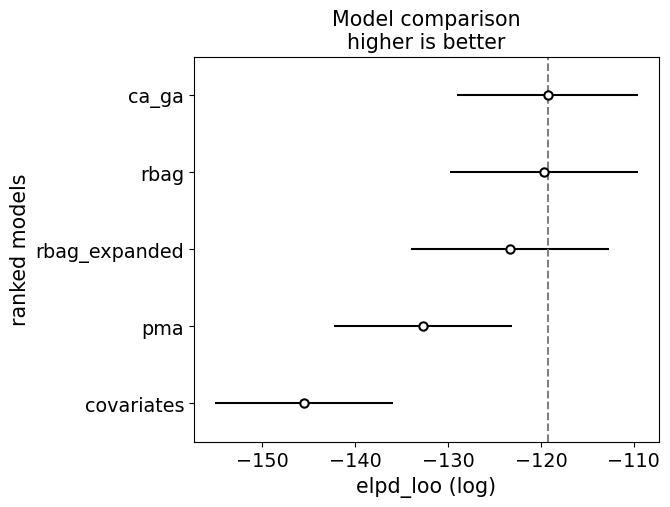

In [18]:
comparison = az.compare({
    'covariates': results_covars,
    'pma': results_pma, 
    'ca_ga': results_caga,
    'rbag': results_rbag,
    'rbag_expanded': results_rbag_expanded
})

print(comparison)
az.plot_compare(comparison)

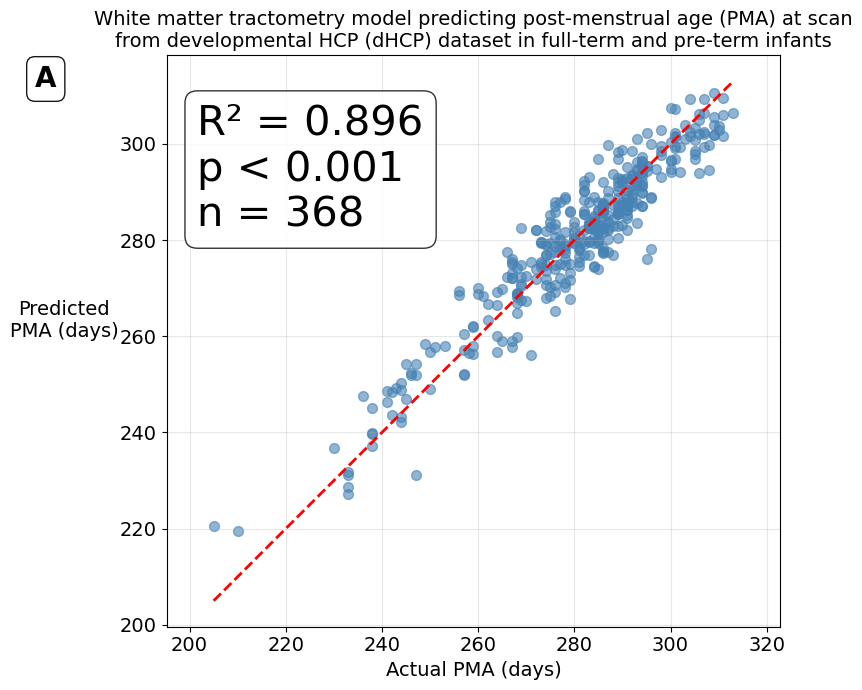

In [19]:
# Load dHCP full results
with open("dhcp_dedup_100_famd_n1_pma.pkl", "rb") as fp:
    dhcp_full_all_results = pickle.load(fp)

dhcp_full_preds = average_cv_predictions(dhcp_full_all_results['Covariates Not Regressed'])

# Plot
plt.figure(figsize=(8, 7))
y_true = dhcp_full_preds['y_true']
y_pred = dhcp_full_preds['y_pred']
r2 = r2_score(y_true, y_pred)
r, p_value = pearsonr(y_true, y_pred)

plt.scatter(y_true, y_pred, alpha=0.6, s=50, color='steelblue')

min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# Enhanced annotation with p-value
if p_value < 0.001:
    p_text = 'p < 0.001'
else:
    p_text = f'p = {p_value:.3f}'

plt.text(0.05, 0.7, f'R² = {r2:.3f}\n{p_text}\nn = {len(y_true)}', 
         transform=plt.gca().transAxes, fontsize=30,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Actual PMA (days)', fontsize=14)
plt.ylabel('Predicted\nPMA (days)', fontsize=14, rotation=0, labelpad=40)

title = ("White matter tractometry model predicting post-menstrual age (PMA) at scan\n"
         "from developmental HCP (dHCP) dataset in full-term and pre-term infants")
plt.title(title, fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.text(0.05, 0.9, 'A', transform=plt.gcf().transFigure, 
         fontsize=20, fontweight='bold', verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()

# plt.savefig('dHCPfull.png', bbox_inches='tight')
plt.show()

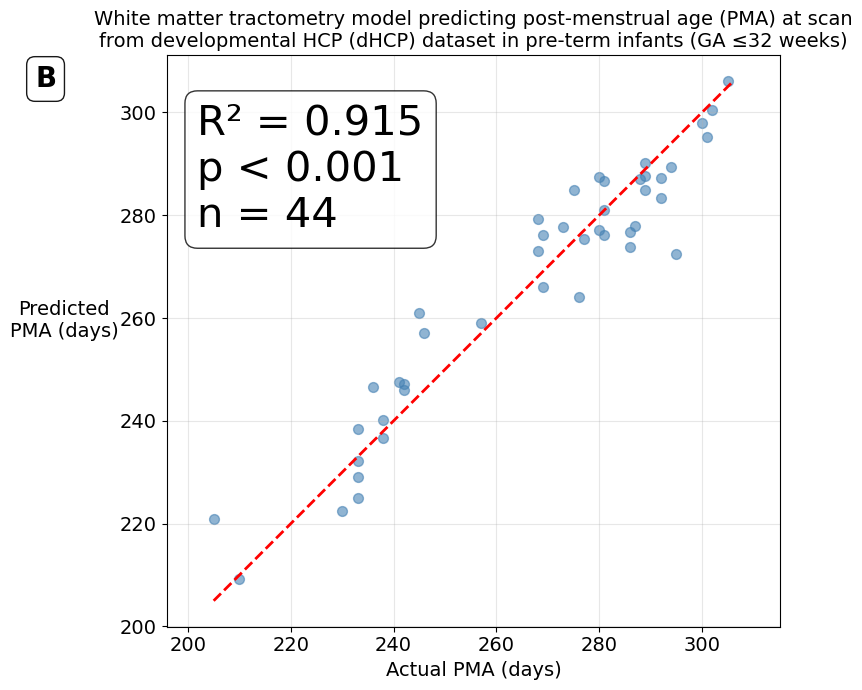

In [20]:
# Load dHCP GA≤224 results
with open("dhcp_ga224_100_famd_n1_pma.pkl", "rb") as fp:
    dhcp_ga224_all_results = pickle.load(fp)

dhcp_ga224_preds = average_cv_predictions(dhcp_ga224_all_results['Covariates Not Regressed'])

# Plot
plt.figure(figsize=(8, 7))
y_true = dhcp_ga224_preds['y_true']
y_pred = dhcp_ga224_preds['y_pred']
r2 = r2_score(y_true, y_pred)
r, p_value = pearsonr(y_true, y_pred)

plt.scatter(y_true, y_pred, alpha=0.6, s=50, color='steelblue')

min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

if p_value < 0.001:
    p_text = 'p < 0.001'
else:
    p_text = f'p = {p_value:.3f}'

plt.text(0.05, 0.7, f'R² = {r2:.3f}\n{p_text}\nn = {len(y_true)}', 
         transform=plt.gca().transAxes, fontsize=30,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Actual PMA (days)', fontsize=14)
plt.ylabel('Predicted\nPMA (days)', fontsize=14, rotation=0, labelpad=40)

title = ("White matter tractometry model predicting post-menstrual age (PMA) at scan\n"
          "from developmental HCP (dHCP) dataset in pre-term infants (GA ≤32 weeks)")

plt.title(title, fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.text(0.05, 0.9, 'B', transform=plt.gcf().transFigure, 
         fontsize=20, fontweight='bold', verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()

# plt.savefig('dHCPpreterm.png', bbox_inches='tight')
plt.show()

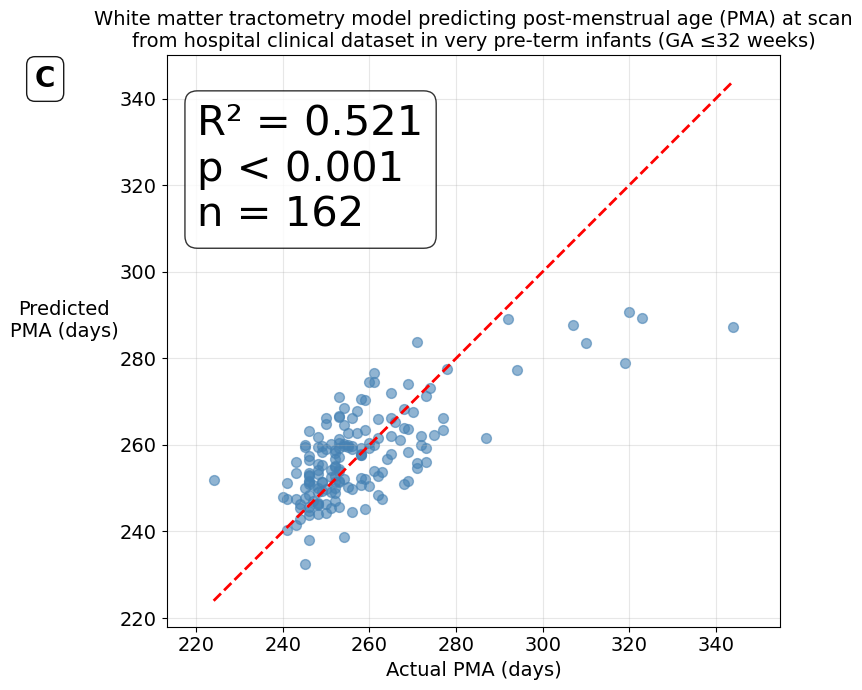

In [21]:
# Load LPCH results
with open("lpch_100_famd_n1_pma.pkl", "rb") as fp:
    lpch_all_results = pickle.load(fp)

lpch_preds = average_cv_predictions(lpch_all_results['Covariates Not Regressed'])

# Plot
plt.figure(figsize=(8, 7))
y_true = lpch_preds['y_true']
y_pred = lpch_preds['y_pred']
r2 = r2_score(y_true, y_pred)
r, p_value = pearsonr(y_true, y_pred)

plt.scatter(y_true, y_pred, alpha=0.6, s=50, color='steelblue')

min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

if p_value < 0.001:
    p_text = 'p < 0.001'
else:
    p_text = f'p = {p_value:.3f}'

plt.text(0.05, 0.7, f'R² = {r2:.3f}\n{p_text}\nn = {len(y_true)}', 
         transform=plt.gca().transAxes, fontsize=30,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Actual PMA (days)', fontsize=14)
plt.ylabel('Predicted\nPMA (days)', fontsize=14, rotation=0, labelpad=40)

title = ("White matter tractometry model predicting post-menstrual age (PMA) at scan\n"
        "from hospital clinical dataset in very pre-term infants (GA ≤32 weeks)")

plt.title(title, fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.text(0.05, 0.9, 'C', transform=plt.gcf().transFigure, 
         fontsize=20, fontweight='bold', verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()

# plt.savefig('LPCH.png', bbox_inches='tight')
plt.show()

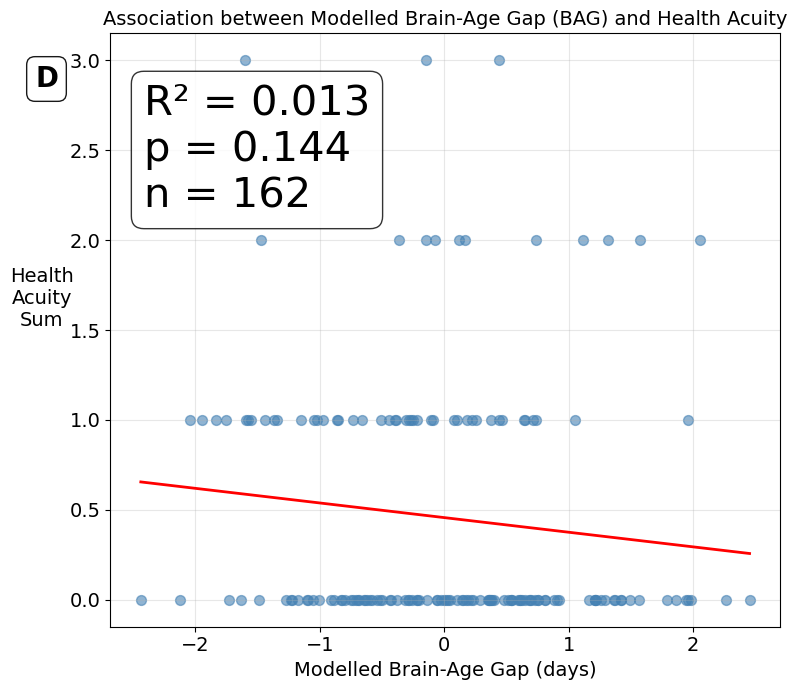

In [22]:
# Create the plot
plt.figure(figsize=(8, 7))

# Remove any NaN values for plotting
plot_data = df_modeldata[['rbag', 'health_acuity_sum']].dropna()

# Calculate R²
slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data['rbag'], plot_data['health_acuity_sum'])
r_squared = r_value**2

# Create scatterplot
plt.scatter(plot_data['rbag'], plot_data['health_acuity_sum'], 
           alpha=0.6, s=50, color='steelblue')

# Add regression line
x_line = np.linspace(plot_data['rbag'].min(), plot_data['rbag'].max(), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='red', linewidth=2)

# Add R² annotation with sample size
plt.text(0.05, 0.915, f'R² = {r_squared:.3f}\np = {p_value:.3f}\nn = {len(plot_data)}', 
         transform=plt.gca().transAxes, fontsize=30, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Modelled Brain-Age Gap (days)', fontsize=14)
plt.ylabel('Health\nAcuity\nSum', fontsize=14, rotation=0, labelpad=20)
plt.title('Association between Modelled Brain-Age Gap (BAG) and Health Acuity', fontsize=14)

plt.text(0.05, 0.9, 'D', transform=plt.gcf().transFigure, 
         fontsize=20, fontweight='bold', verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# plt.savefig('BAGhealth.png', bbox_inches='tight')
plt.show()